***The project will require you to research and propose a sentiment analysis algorithm for text. You will need to use at least two public datasets, three machine learning algorithms, and two deep learning algorithms. You will also need to use augmentation techniques, normalization, and different types of loss functions.***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/twitterDataset'

/content/drive/MyDrive/twitterDataset


### **Download libraries**

In [4]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [5]:
import numpy as np
import spacy
import re

from sklearn.utils import shuffle
from string import punctuation
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import auc, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
!python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


### **Loading Dataset**

In [7]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/twitterDataset/training.1600000.processed.noemoticon.csv', delimiter=',', encoding='ISO-8859-1')
df

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1048567,4,1960186342,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Madelinedugganx,My GrandMa is making Dinenr with my Mum
1048568,4,1960186409,Fri May 29 07:33:43 PDT 2009,NO_QUERY,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
1048569,4,1960186429,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Falchion,@ShaDeLa same here say it like from the Termi...
1048570,4,1960186445,Fri May 29 07:33:44 PDT 2009,NO_QUERY,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?


In [8]:
df.columns = ['sentiment','id','date','query','user','text']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1048572 non-null  int64 
 1   id         1048572 non-null  int64 
 2   date       1048572 non-null  object
 3   query      1048572 non-null  object
 4   user       1048572 non-null  object
 5   text       1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [10]:
df['sentiment'].value_counts()

0    799996
4    248576
Name: sentiment, dtype: int64

In [11]:
df.describe()

,sentiment,id
count,1.048572e+06,1.048572e+06
mean,9.482458e-01,1.976168e+09
std,1.701122e+00,2.300567e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.824526e+09
50%,0.000000e+00,1.990870e+09
75%,0.000000e+00,2.198903e+09
max,4.000000e+00,2.329206e+09


In [12]:
df['sentiment'] = df['sentiment'].replace({4:1})

In [13]:
df['sentiment'].value_counts()

0    799996
1    248576
Name: sentiment, dtype: int64

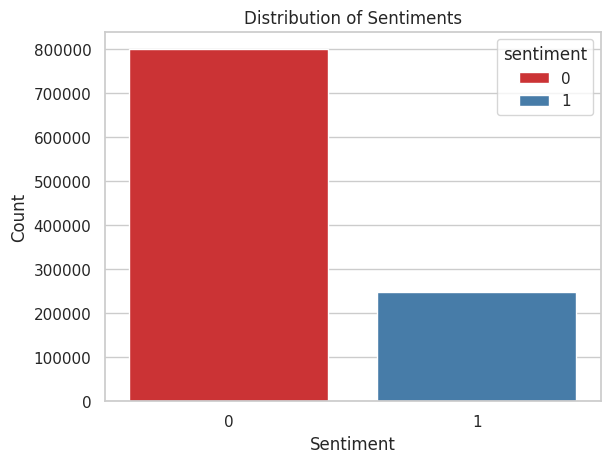

In [14]:
sns.set(style="whitegrid")

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set1')

# Customize plot labels and title if needed:
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot:
plt.show()

In [15]:

df['text'].isnull().sum()
df = df.drop_duplicates('text')

In [16]:
test_df = pd.read_csv('/content/drive/MyDrive/twitterDataset/testdata.manual.2009.06.14.csv', encoding = 'latin-1')
test_df

,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
...,...,...,...,...,...,...
510,4,14083,Mon May 11 03:33:38 UTC 2009,nashta,theviewfans,House Correspondents dinner was last night who...
511,4,14084,Mon May 11 05:22:12 UTC 2009,nashta,peterlikewhat,lebron and zydrunas are such an awesome duo
512,4,14085,Mon May 11 05:22:37 UTC 2009,nashta,emceet,@wordwhizkid Lebron is a beast... nobody in th...
513,4,14086,Mon May 11 05:21:45 UTC 2009,nashta,Native_011,@Pmillzz lebron IS THE BOSS


### **Preprocessing**

In [17]:
stuff_to_be_removed = list(punctuation)

def textprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE)
    text=re.sub("(\\d|\\W)+"," ",text)
    text = re.sub(r'\@\w+|\#'," ",text)
    text = re.sub(r'[^\w\s\`]'," ",text)
    text_tokens = word_tokenize(text)
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed]
    text1 = " ".join(text)

    return text1

In [18]:
data_cleaned = pd.DataFrame()

df['text'] = df['text'].apply(textprocessing)
df['text'].head()

<ipython-input-18-718bf548a391>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(textprocessing)


0    is upset that he can t updat his facebook by t...
1    kenichan i dive mani time for the ball manag t...
2         my whole bodi feel itchi and like it on fire
3    nationwideclass no it s not behav at all i m m...
4                          kwesidei not the whole crew
Name: text, dtype: object

In [19]:
df_train = shuffle(df)
df_train[:100]

,sentiment,id,date,query,user,text
58467,0,1685904327,Sun May 03 02:42:04 PDT 2009,NO_QUERY,Sandypop,gillianr shop good though isn t it i m plan on...
1045787,1,1957586360,Fri May 29 00:58:07 PDT 2009,NO_QUERY,siimpLybeautii,cuhz i m loos off that goos http twitpic com pk
179639,0,1966313398,Fri May 29 17:32:11 PDT 2009,NO_QUERY,GCJoni,i should be pay my bill and not play on here
35613,0,1565295840,Mon Apr 20 06:24:37 PDT 2009,NO_QUERY,MUWarrior,and rain damn you treadmil here i come
561389,0,2205414193,Wed Jun 17 04:41:10 PDT 2009,NO_QUERY,BecReedman,braveheart hard to find a new job in this clim...
...,...,...,...,...,...,...
675460,0,2248099995,Fri Jun 19 20:06:05 PDT 2009,NO_QUERY,AlyssaMeyer,spacey what
3525,0,1468620198,Tue Apr 07 02:46:31 PDT 2009,NO_QUERY,Niczy,donniewahlberg donni when are you come back to...
372471,0,2050745322,Fri Jun 05 19:13:04 PDT 2009,NO_QUERY,Love_NeverEnds,on my way back from zach bday he s not a babi ...
836959,1,1558619313,Sun Apr 19 08:55:15 PDT 2009,NO_QUERY,Nikaz,tawnyheath are you go to get your song on itun...


In [20]:
negative_text = ' '.join(df[df['sentiment'] == 0]['text'])
positive_text = ' '.join(df[df['sentiment'] == 1]['text'])
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,0,is upset that he can t updat his facebook by t...
1,0,kenichan i dive mani time for the ball manag t...
2,0,my whole bodi feel itchi and like it on fire
3,0,nationwideclass no it s not behav at all i m m...
4,0,kwesidei not the whole crew


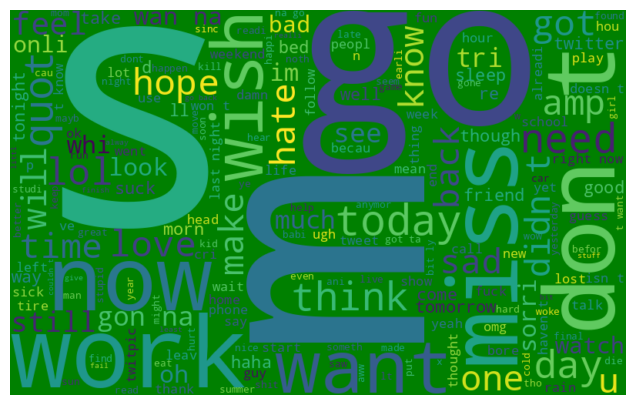

In [21]:
wordcloud = WordCloud(width=800, height=500, background_color='green').generate(negative_text)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

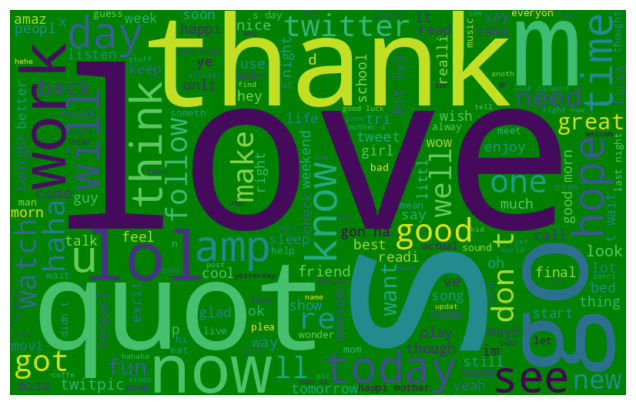

In [22]:
wordcloud = WordCloud(width=800, height=500, background_color='green').generate(positive_text)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### **Feature Scaling**

In [23]:
X = df_train['text']
y = df_train['sentiment']

vectorizer = tf()
vectors = vectorizer.fit_transform(X)

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(vectors, y, test_size=0.2, random_state=52)

X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=52)

### **Machine Learning Models**

In [25]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)

X_train_pca = svd.fit_transform(X_train)
X_validation_pca = svd.transform(X_validation)
X_test_pca = svd.transform(X_test)

#### ***Support Vector Machine***

In [ ]:
svm_model = LinearSVC(dual = True)
svm_model.fit(X_train_pca, y_train)


y_pred_validation = svm_model.predict(X_validation_pca)
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Accuracy on the validation set: {accuracy_validation}")


y_pred_test = svm_model.predict(X_test_pca)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on the test set: {accuracy_test}")

Accuracy on the validation set: 0.7918504434771698
Accuracy on the test set: 0.7923543150539503


#### ***Decision Tree***

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"DecisionTree:{accuracy * 100:.2f}%")

precision = precision_score(y_test, y_pred, average='macro')
print(f"DecisionTree - Precision: {precision * 100:.2f}%")

recall = recall_score(y_test, y_pred, average='macro')
print(f"DecisionTree:{recall * 100:.2f}%")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"DecisionTree F1:{f1 * 100:.2f}%")

DecisionTree:70.72%
DecisionTree - Precision: 60.19%
DecisionTree:60.62%
DecisionTree F1:60.38%


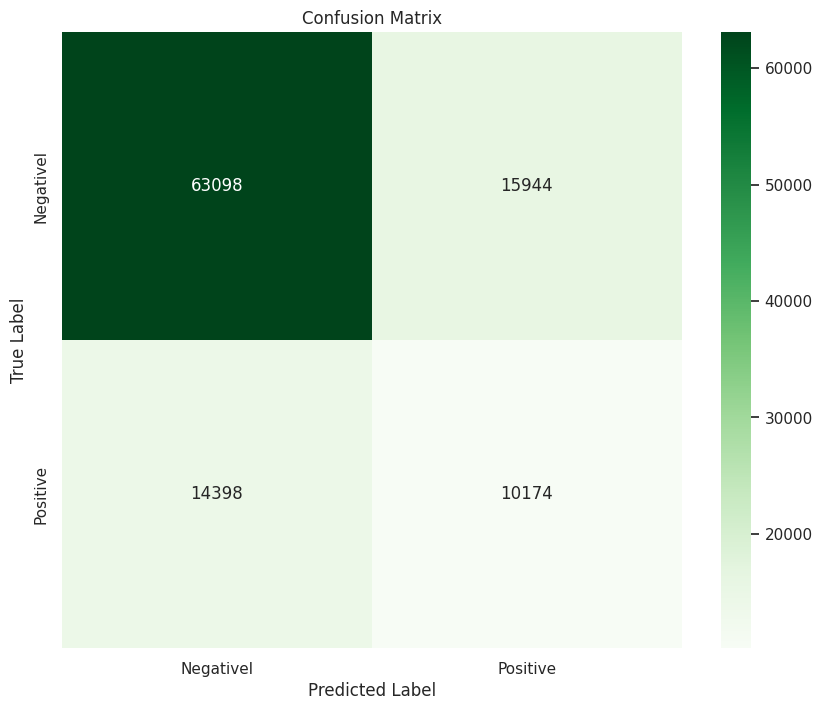

In [ ]:
label = ['Negativel', 'Positive']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### ***XGBosst***

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost - Accuracy: {accuracy * 100:.2f}%")

precision = precision_score(y_test, y_pred, average='macro')
print(f"XGBoost - Precision: {precision * 100:.2f}%")

recall = recall_score(y_test, y_pred, average='macro')
print(f"XGBoost - Recall: {recall * 100:.2f}%")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"XGBoost - F1: {f1 * 100:.2f}%")

XGBoost - Accuracy: 80.18%
XGBoost - Precision: 74.71%
XGBoost - Recall: 63.55%
XGBoost - F1: 65.65%


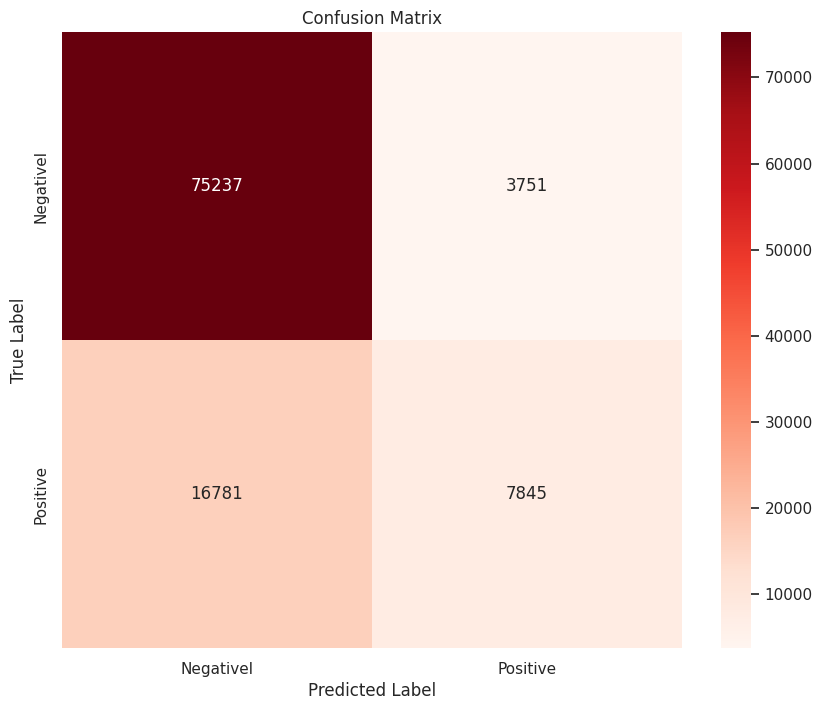

In [ ]:
label = ['Negativel', 'Positive']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### ***Random Forest***

In [ ]:
clf = RandomForestClassifier(max_depth=19, random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost - Accuracy: {accuracy * 100:.2f}%")

precision = precision_score(y_test, y_pred, average='macro')
print(f"XGBoost - Precision: {precision * 100:.2f}%")

recall = recall_score(y_test, y_pred, average='macro')
print(f"XGBoost - Recall: {recall * 100:.2f}%")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"XGBoost - F1: {f1 * 100:.2f}%")

XGBoost - Accuracy: 79.33%
XGBoost - Precision: 79.38%
XGBoost - Recall: 58.07%
XGBoost - F1: 58.34%


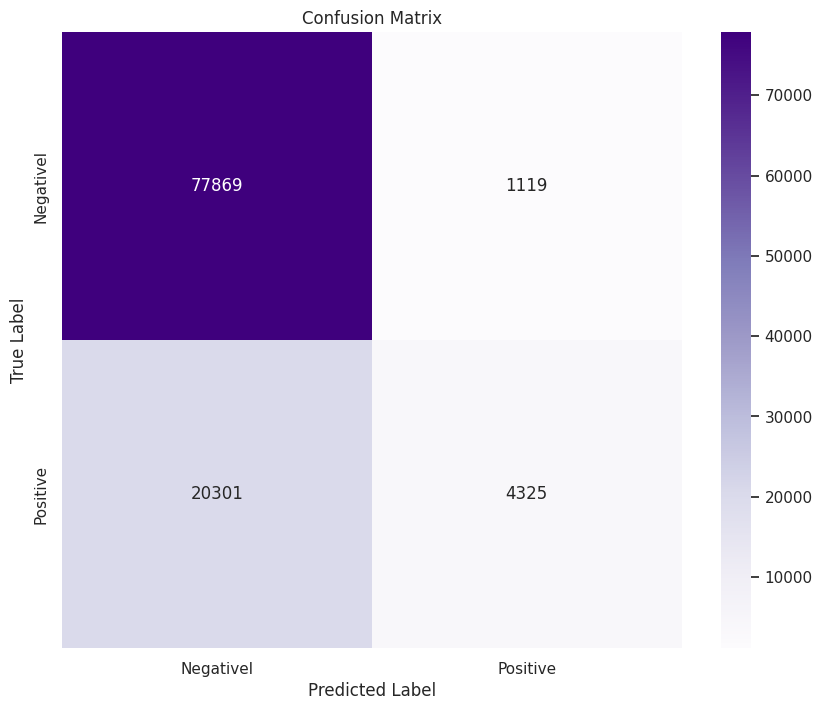

In [ ]:
label = ['Negativel', 'Positive']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **Deep Learning Models**

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Dense,SimpleRNN,Embedding,Flatten

In [ ]:
import pandas as pd
train_ds = pd.read_csv('/content/drive/MyDrive/twitterDataset/train.csv',encoding='latin1');
validation_ds = pd.read_csv('/content/drive/MyDrive/twitterDataset/test.csv',encoding='latin1');

In [ ]:
train_ds = train_ds[['text','sentiment']]
validation_ds = validation_ds[['text','sentiment']]

In [ ]:
train_ds['text'].fillna('',inplace=True)
validation_ds['text'].fillna('',inplace=True)

In [ ]:
def func(sentiment):
    if sentiment =='positive':
        return 0;
    elif sentiment =='negative':
        return 1;
    else:
        return 2;
train_ds['sentiment'] = train_ds['sentiment'].apply(func)
validation_ds['sentiment'] = validation_ds['sentiment'].apply(func)

In [ ]:
x_train = np.array(train_ds['text'].tolist())
y_train = np.array(train_ds['sentiment'].tolist())
x_test = np.array(validation_ds['text'].tolist())
y_test = np.array(validation_ds['sentiment'].tolist())

In [ ]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
tokenizer = Tokenizer(num_words=20000)

In [ ]:
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
from keras.utils import pad_sequences
x_train = pad_sequences(x_train, padding='post', maxlen=35)  # Set maxlen to 35
x_test = pad_sequences(x_test, padding='post', maxlen=35)

In [ ]:
# Using RNN

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=5, input_length=35))
model.add(SimpleRNN(32,return_sequences=False))
model.add(Dense(3,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 5)             100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 101315 (395.76 KB)
Trainable params: 101315 (395.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
859/859 [==============================] - 12s 12ms/step - loss: 1.0102 - accuracy: 0.4797 - val_loss: 0.8281 - val_accuracy: 0.6960
Epoch 2/10
859/859 [==============================] - 10s 12ms/step - loss: 0.7900 - accuracy: 0.6470 - val_loss: 0.6527 - val_accuracy: 0.7597
Epoch 3/10
859/859 [==============================] - 9s 10ms/step - loss: 0.6266 - accuracy: 0.7458 - val_loss: 0.6503 - val_accuracy: 0.7429
Epoch 4/10
859/859 [==============================] - 10s 11ms/step - loss: 0.5032 - accuracy: 0.8082 - val_loss: 0.6168 - val_accuracy: 0.7400
Epoch 5/10
859/859 [==============================] - 10s 12ms/step - loss: 0.4025 - accuracy: 0.8546 - val_loss: 0.6297 - val_accuracy: 0.7489
Epoch 6/10
859/859 [==============================] - 10s 12ms/step - loss: 0.3349 - accuracy: 0.8845 - val_loss: 0.6837 - val_accuracy: 0.7400
Epoch 7/10
859/859 [==============================] - 9s 10ms/step - loss: 0.2876 - accuracy: 0.9028 - val_loss: 0.8050 - val_accuracy: 0

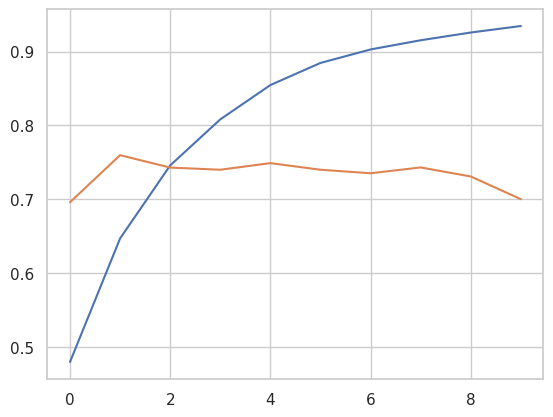

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
# Prediction 1
text = "The movie was bad bad bad, i will not recommend this movie to anyone"

new_text_seq = tokenizer.texts_to_sequences([text])
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)  # Use the max_len determined during training
predictions = model.predict(new_text_padded)
predicted_class_index = predictions.argmax(axis=-1)
if predicted_class_index[0] == 0:
    print("Postive Sentiment");
elif predicted_class_index[0] == 1:
    print("Negative Sentiment")
else:
    print("Neutral Sentiment")

1/1 [==============================] - 0s 213ms/step
Negative Sentiment


In [ ]:
# Prediction 2

text = "The movie was good, i will recommend this movie to anyone"

new_text_seq = tokenizer.texts_to_sequences([text])
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)  # Use the max_len determined during training
predictions = model.predict(new_text_padded)
predicted_class_index = predictions.argmax(axis=-1)
if predicted_class_index[0] == 0:
    print("Postive Sentiment");
elif predicted_class_index[0] == 1:
    print("Negative Sentiment")
else:
    print("Neutral Sentiment")

1/1 [==============================] - 0s 23ms/step
Postive Sentiment


### **Using LSTM**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Embedding(input_dim=20000, output_dim=5, input_length=35))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 5)             100000    
                                                                 
 lstm_6 (LSTM)               (None, 35, 64)            17920     
                                                                 
 dropout_6 (Dropout)         (None, 35, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 35, 64)            33024     
                                                                 
 dropout_7 (Dropout)         (None, 35, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 35, 64)            33024     
                                                                 
 dropout_8 (Dropout)         (None, 35, 64)           

In [ ]:
#Saving our Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('/content/drive/MyDrive/models/tw.h', save_best_only=True)
#Hyper-parameters of our model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [ ]:
#Fitiing our training our model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, callbacks=[cp])

Epoch 1/20
859/859 [==============================] - 75s 79ms/step - loss: 0.6329 - accuracy: 0.4042 - auc: 0.5590 - val_loss: 0.5720 - val_accuracy: 0.5632 - val_auc: 0.7862
Epoch 2/20
859/859 [==============================] - 70s 81ms/step - loss: 0.5725 - accuracy: 0.5180 - auc: 0.7036 - val_loss: 0.4568 - val_accuracy: 0.6633 - val_auc: 0.8423
Epoch 3/20
859/859 [==============================] - 68s 79ms/step - loss: 0.5173 - accuracy: 0.5968 - auc: 0.7788 - val_loss: 0.4329 - val_accuracy: 0.6777 - val_auc: 0.8563
Epoch 4/20
859/859 [==============================] - 57s 67ms/step - loss: 0.4822 - accuracy: 0.6461 - auc: 0.8159 - val_loss: 0.4335 - val_accuracy: 0.6876 - val_auc: 0.8600
Epoch 5/20
859/859 [==============================] - 71s 83ms/step - loss: 0.4506 - accuracy: 0.6867 - auc: 0.8426 - val_loss: 0.4236 - val_accuracy: 0.7018 - val_auc: 0.8653
Epoch 6/20
859/859 [==============================] - 72s 84ms/step - loss: 0.4231 - accuracy: 0.7175 - auc: 0.8629 - va

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/MyDrive/models/tw.h')

In [ ]:
test_predictions = (best_model.predict(x_test) > 0.5).astype(int)
from sklearn.metrics import classification_report

print(classification_report(y_test, test_predictions))

151/151 [==============================] - 7s 33ms/step
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      1103
           1       0.48      0.48      0.48      1001
           2       0.83      0.76      0.79      2711

   micro avg       0.74      0.67      0.70      4815
   macro avg       0.69      0.61      0.65      4815
weighted avg       0.74      0.67      0.70      4815
 samples avg       0.67      0.67      0.67      4815



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
